## Crypto Prediction with LSTM: Ethereum (ETH)

## 30 Day lookback

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained
- This update uses a 30 day lookback window, in order to assess whether the greater lookback time has an impact on training and prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt

import nasdaqdatalink

from api_keys import coinapi_key

2023-09-18 18:21:09.286851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-18T00:00:00.0000000Z', 'time_period_end': '2023-09-19T00:00:00.0000000Z', 'time_open': '2023-09-18T00:00:07.0460000Z', 'time_close': '2023-09-18T22:20:57.6320000Z', 'price_open': 1623.3, 'price_high': 1669.2, 'price_low': 1606, 'price_close': 1640.6, 'volume_traded': 3843.61805174, 'trades_count': 5363}, {'time_period_start': '2023-09-17T00:00:00.0000000Z', 'time_period_end': '2023-09-18T00:00:00.0000000Z', 'time_open': '2023-09-17T00:00:22.7270000Z', 'time_close': '2023-09-17T23:59:45.8490000Z', 'price_open': 1634.9, 'price_high': 1635.6, 'price_low': 1613, 'price_close': 1623.3, 'volume_traded': 1544.80676936, 'trades_count': 3412}, {'time_period_start': '2023-09-16T00:00:00.0000000Z', 'time_period_end': '2023-09-17T00:00:00.0000000Z', 'time_open': '2023-09-16T00:00:18.8370000Z', 'time_close': '2023-09-16T23:59:46.7840000Z', 'price_open': 1642.4, 'price_high': 1652.3, 'price_low': 1632.1, 'price_close': 1635, 'volume_traded': 1343.66683579, 'trades_cou

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-18T00:00:00.0000000Z,2023-09-19T00:00:00.0000000Z,2023-09-18T00:00:07.0460000Z,2023-09-18T22:20:57.6320000Z,1623.3,1669.2,1606.0,1640.6,3843.618052,5363
1,2023-09-17T00:00:00.0000000Z,2023-09-18T00:00:00.0000000Z,2023-09-17T00:00:22.7270000Z,2023-09-17T23:59:45.8490000Z,1634.9,1635.6,1613.0,1623.3,1544.806769,3412
2,2023-09-16T00:00:00.0000000Z,2023-09-17T00:00:00.0000000Z,2023-09-16T00:00:18.8370000Z,2023-09-16T23:59:46.7840000Z,1642.4,1652.3,1632.1,1635.0,1343.666836,3983
3,2023-09-15T00:00:00.0000000Z,2023-09-16T00:00:00.0000000Z,2023-09-15T00:00:00.4470000Z,2023-09-15T23:59:48.2460000Z,1627.1,1653.1,1612.0,1641.5,3623.074399,5783
4,2023-09-14T00:00:00.0000000Z,2023-09-15T00:00:00.0000000Z,2023-09-14T00:00:04.4670000Z,2023-09-14T23:59:58.0310000Z,1608.1,1644.4,1607.5,1627.1,5650.199148,5572


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-08-20,298.40
2017-08-21,319.31
2017-08-22,312.22
2017-08-23,315.61
2017-08-24,323.84


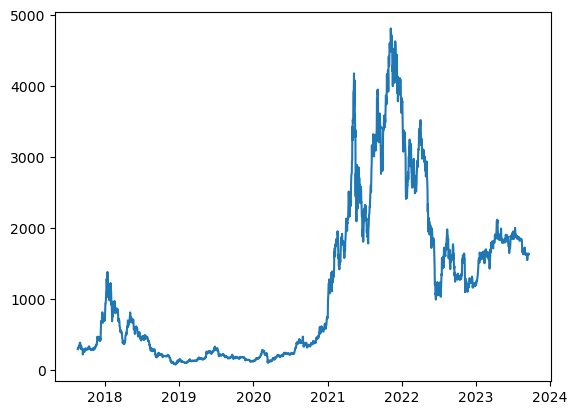

In [5]:
#plot historical eth price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 30

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

# scale to log
log_transformed_data = np.log(shifted_df_as_np)



# split y from features
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((2181, 30), (2181,), (2181,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1744, 30), (1744,), (218, 30), (218,), (219, 30), (219,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-18 18:21:28.332859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
55/55 [==============================] - 5s 35ms/step - loss: 31.4309 - mean_absolute_error: 5.3835 - val_loss: 12.5129 - val_mean_absolute_error: 3.5344
Epoch 2/100
55/55 [==============================] - 1s 20ms/step - loss: 1.9615 - mean_absolute_error: 1.1603 - val_loss: 0.7238 - val_mean_absolute_error: 0.8391
Epoch 3/100
55/55 [==============================] - 1s 22ms/step - loss: 0.8221 - mean_absolute_error: 0.7652 - val_loss: 0.0474 - val_mean_absolute_error: 0.1773
Epoch 4/100
55/55 [==============================] - 1s 19ms/step - loss: 0.1486 - mean_absolute_error: 0.2982 - val_loss: 0.2148 - val_mean_absolute_error: 0.4073
Epoch 5/100
55/55 [==============================] - 1s 19ms/step - loss: 0.0608 - mean_absolute_error: 0.1960 - val_loss: 0.1223 - val_mean_absolute_error: 0.2992
Epoch 6/100
55/55 [==============================] - 1s 19ms/step - loss: 0.0338 - mean_absolute_error: 0.1445 - val_loss: 0.0228 - val_mean_absolute_error: 0.1239
Epoch 7/100
55

Epoch 51/100
55/55 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_absolute_error: 0.0496 - val_loss: 0.0027 - val_mean_absolute_error: 0.0366
Epoch 52/100
55/55 [==============================] - 1s 19ms/step - loss: 0.0050 - mean_absolute_error: 0.0534 - val_loss: 0.0068 - val_mean_absolute_error: 0.0696
Epoch 53/100
55/55 [==============================] - 1s 18ms/step - loss: 0.0044 - mean_absolute_error: 0.0488 - val_loss: 0.0028 - val_mean_absolute_error: 0.0378
Epoch 54/100
55/55 [==============================] - 1s 16ms/step - loss: 0.0045 - mean_absolute_error: 0.0502 - val_loss: 0.0023 - val_mean_absolute_error: 0.0331
Epoch 55/100
55/55 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_absolute_error: 0.0456 - val_loss: 0.0052 - val_mean_absolute_error: 0.0593
Epoch 56/100
55/55 [==============================] - 1s 17ms/step - loss: 0.0064 - mean_absolute_error: 0.0625 - val_loss: 0.0047 - val_mean_absolute_error: 0.0556
Epoch 57/1

55/55 [==============================] - 1s 5ms/step


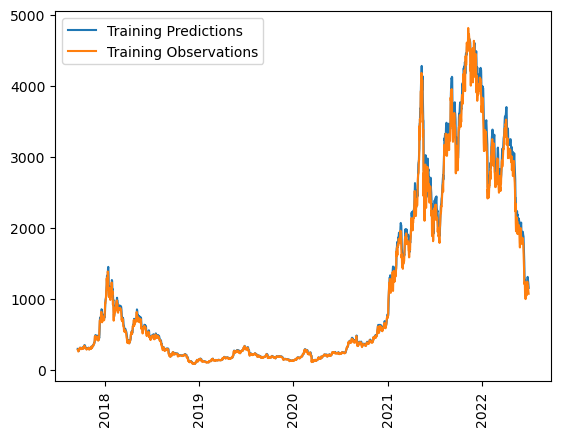

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.004112334921956062
Val MAE: 0.05299874022603035


7/7 [==============================] - 0s 6ms/step


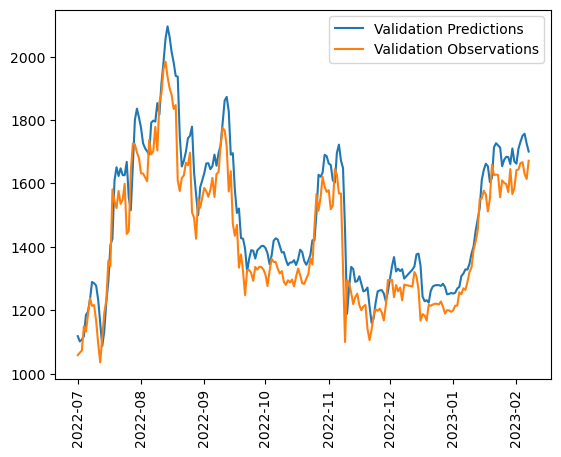

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0032465888652950525
Test MAE: 0.05278531089425087


7/7 [==============================] - 0s 7ms/step


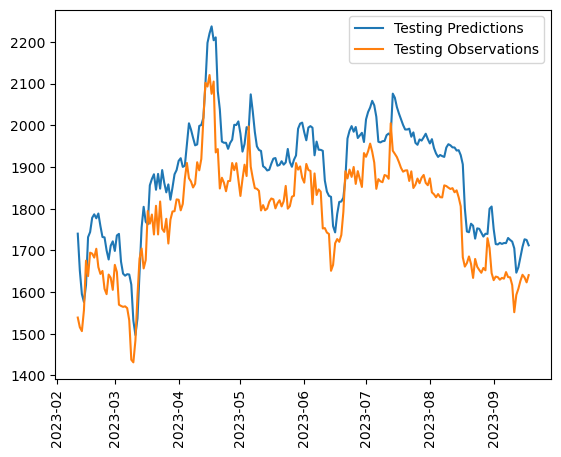

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.38971479730248415


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((851,),
 (851, 30),
 (851,),
 (130,),
 (130, 30),
 (130,),
 (110,),
 (110, 30),
 (110,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
27/27 [==============================] - 3s 37ms/step - loss: 59.2886 - mean_absolute_error: 7.6691 - val_loss: 55.9044 - val_mean_absolute_error: 7.4764
Epoch 2/200
27/27 [==============================] - 0s 17ms/step - loss: 54.9173 - mean_absolute_error: 7.3805 - val_loss: 52.6760 - val_mean_absolute_error: 7.2573
Epoch 3/200
27/27 [==============================] - 0s 17ms/step - loss: 52.2063 - mean_absolute_error: 7.1951 - val_loss: 50.0852 - val_mean_absolute_error: 7.0766
Epoch 4/200
27/27 [==============================] - 0s 16ms/step - loss: 49.4197 - mean_absolute_error: 6.9989 - val_loss: 46.9215 - val_mean_absolute_error: 6.8494
Epoch 5/200
27/27 [==============================] - 0s 17ms/step - loss: 45.5355 - mean_absolute_error: 6.7157 - val_loss: 42.0219 - val_mean_absolute_error: 6.4819
Epoch 6/200
27/27 [==============================] - 0s 18ms/step - loss: 39.5039 - mean_absolute_error: 6.2486 - val_loss: 34.6698 - val_mean_absolute_error: 5.8875
Epoc

27/27 [==============================] - 0s 17ms/step - loss: 0.0136 - mean_absolute_error: 0.0903 - val_loss: 0.0027 - val_mean_absolute_error: 0.0419
Epoch 51/200
27/27 [==============================] - 0s 16ms/step - loss: 0.0135 - mean_absolute_error: 0.0903 - val_loss: 0.0027 - val_mean_absolute_error: 0.0422
Epoch 52/200
27/27 [==============================] - 0s 17ms/step - loss: 0.0129 - mean_absolute_error: 0.0883 - val_loss: 0.0023 - val_mean_absolute_error: 0.0393
Epoch 53/200
27/27 [==============================] - 0s 18ms/step - loss: 0.0127 - mean_absolute_error: 0.0878 - val_loss: 0.0030 - val_mean_absolute_error: 0.0432
Epoch 54/200
27/27 [==============================] - 0s 17ms/step - loss: 0.0131 - mean_absolute_error: 0.0894 - val_loss: 0.0023 - val_mean_absolute_error: 0.0389
Epoch 55/200
27/27 [==============================] - 0s 17ms/step - loss: 0.0121 - mean_absolute_error: 0.0848 - val_loss: 0.0021 - val_mean_absolute_error: 0.0375
Epoch 56/200
27/27 [===

Epoch 100/200
27/27 [==============================] - 0s 18ms/step - loss: 0.0076 - mean_absolute_error: 0.0664 - val_loss: 0.0023 - val_mean_absolute_error: 0.0388
Epoch 101/200
27/27 [==============================] - 0s 18ms/step - loss: 0.0076 - mean_absolute_error: 0.0659 - val_loss: 0.0027 - val_mean_absolute_error: 0.0424
Epoch 102/200
27/27 [==============================] - 0s 18ms/step - loss: 0.0076 - mean_absolute_error: 0.0660 - val_loss: 0.0025 - val_mean_absolute_error: 0.0399
Epoch 103/200
27/27 [==============================] - 0s 18ms/step - loss: 0.0075 - mean_absolute_error: 0.0659 - val_loss: 0.0016 - val_mean_absolute_error: 0.0314
Epoch 104/200
27/27 [==============================] - 0s 18ms/step - loss: 0.0074 - mean_absolute_error: 0.0651 - val_loss: 0.0030 - val_mean_absolute_error: 0.0451
Epoch 105/200
27/27 [==============================] - 0s 18ms/step - loss: 0.0077 - mean_absolute_error: 0.0669 - val_loss: 0.0020 - val_mean_absolute_error: 0.0349
Epoc

27/27 [==============================] - 1s 19ms/step - loss: 0.0059 - mean_absolute_error: 0.0577 - val_loss: 0.0013 - val_mean_absolute_error: 0.0282
Epoch 150/200
27/27 [==============================] - 1s 18ms/step - loss: 0.0063 - mean_absolute_error: 0.0608 - val_loss: 0.0014 - val_mean_absolute_error: 0.0283
Epoch 151/200
27/27 [==============================] - 0s 18ms/step - loss: 0.0060 - mean_absolute_error: 0.0586 - val_loss: 0.0013 - val_mean_absolute_error: 0.0281
Epoch 152/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0060 - mean_absolute_error: 0.0580 - val_loss: 0.0019 - val_mean_absolute_error: 0.0348
Epoch 153/200
27/27 [==============================] - 1s 22ms/step - loss: 0.0059 - mean_absolute_error: 0.0584 - val_loss: 0.0016 - val_mean_absolute_error: 0.0306
Epoch 154/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0058 - mean_absolute_error: 0.0565 - val_loss: 0.0017 - val_mean_absolute_error: 0.0323
Epoch 155/200
27/2

27/27 [==============================] - 0s 18ms/step - loss: 0.0053 - mean_absolute_error: 0.0539 - val_loss: 0.0015 - val_mean_absolute_error: 0.0303
Epoch 199/200
27/27 [==============================] - 1s 20ms/step - loss: 0.0049 - mean_absolute_error: 0.0521 - val_loss: 0.0014 - val_mean_absolute_error: 0.0293
Epoch 200/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0053 - mean_absolute_error: 0.0545 - val_loss: 0.0023 - val_mean_absolute_error: 0.0400


27/27 [==============================] - 1s 5ms/step


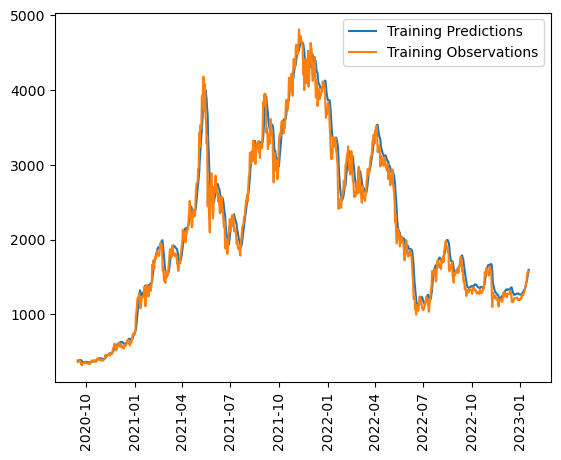

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.002311200136318803
Val MAE: 0.04003318399190903


5/5 [==============================] - 0s 5ms/step


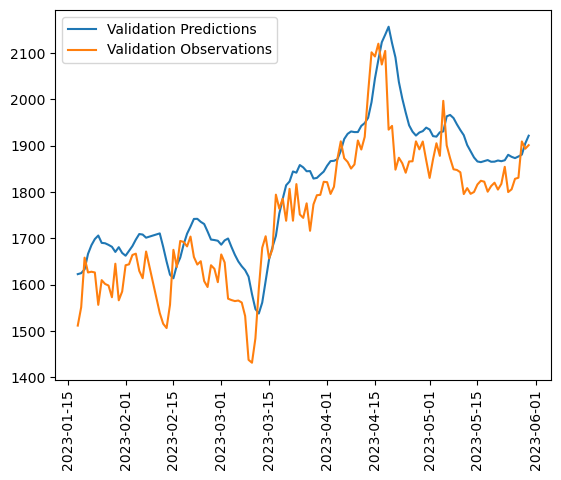

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0018985309870913625
Test MAE: 0.038702670484781265


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 5ms/step
R2 Score:  0.5180416981833292


4/4 [==============================] - 0s 44ms/step


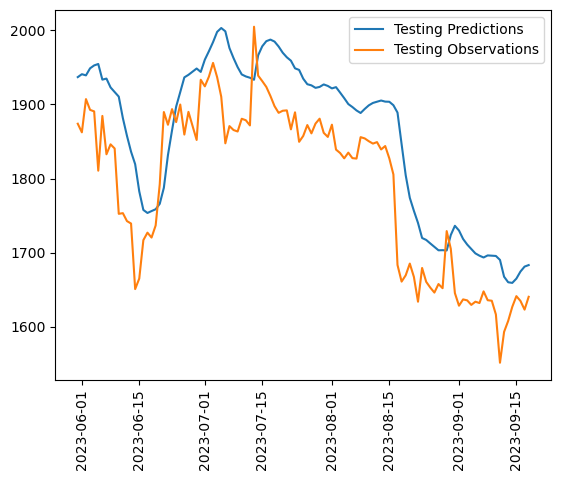

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
27/27 [==============================] - 3s 39ms/step - loss: 22.5677 - mean_absolute_error: 4.1527 - val_loss: 1.5162 - val_mean_absolute_error: 1.2285
Epoch 2/300
27/27 [==============================] - 0s 18ms/step - loss: 1.2050 - mean_absolute_error: 0.9030 - val_loss: 0.0309 - val_mean_absolute_error: 0.1570
Epoch 3/300
27/27 [==============================] - 0s 17ms/step - loss: 0.4349 - mean_absolute_error: 0.5153 - val_loss: 0.0213 - val_mean_absolute_error: 0.1255
Epoch 4/300
27/27 [==============================] - 1s 21ms/step - loss: 0.3849 - mean_absolute_error: 0.4920 - val_loss: 0.0090 - val_mean_absolute_error: 0.0787
Epoch 5/300
27/27 [==============================] - 1s 20ms/step - loss: 0.1402 - mean_absolute_error: 0.2851 - val_loss: 0.0050 - val_mean_absolute_error: 0.0586
Epoch 6/300
27/27 [==============================] - 1s 24ms/step - loss: 0.0301 - mean_absolute_error: 0.1408 - val_loss: 0.0110 - val_mean_absolute_error: 0.0907
Epoch 7/300
27/

Epoch 51/300
27/27 [==============================] - 1s 19ms/step - loss: 0.0042 - mean_absolute_error: 0.0478 - val_loss: 0.0027 - val_mean_absolute_error: 0.0448
Epoch 52/300
27/27 [==============================] - 0s 18ms/step - loss: 0.0067 - mean_absolute_error: 0.0652 - val_loss: 0.0015 - val_mean_absolute_error: 0.0300
Epoch 53/300
27/27 [==============================] - 1s 22ms/step - loss: 0.0047 - mean_absolute_error: 0.0524 - val_loss: 0.0019 - val_mean_absolute_error: 0.0366
Epoch 54/300
27/27 [==============================] - 1s 26ms/step - loss: 0.0045 - mean_absolute_error: 0.0505 - val_loss: 0.0036 - val_mean_absolute_error: 0.0536
Epoch 55/300
27/27 [==============================] - 1s 22ms/step - loss: 0.0047 - mean_absolute_error: 0.0521 - val_loss: 0.0010 - val_mean_absolute_error: 0.0242
Epoch 56/300
27/27 [==============================] - 1s 18ms/step - loss: 0.0040 - mean_absolute_error: 0.0480 - val_loss: 0.0056 - val_mean_absolute_error: 0.0691
Epoch 57/3

27/27 [==============================] - 1s 19ms/step - loss: 0.0054 - mean_absolute_error: 0.0575 - val_loss: 0.0033 - val_mean_absolute_error: 0.0506
Epoch 101/300
27/27 [==============================] - 1s 18ms/step - loss: 0.0035 - mean_absolute_error: 0.0450 - val_loss: 0.0013 - val_mean_absolute_error: 0.0282
Epoch 102/300
27/27 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_absolute_error: 0.0492 - val_loss: 0.0020 - val_mean_absolute_error: 0.0387
Epoch 103/300
27/27 [==============================] - 0s 18ms/step - loss: 0.0043 - mean_absolute_error: 0.0509 - val_loss: 0.0015 - val_mean_absolute_error: 0.0315
Epoch 104/300
27/27 [==============================] - 0s 18ms/step - loss: 0.0038 - mean_absolute_error: 0.0469 - val_loss: 9.1936e-04 - val_mean_absolute_error: 0.0225
Epoch 105/300
27/27 [==============================] - 0s 18ms/step - loss: 0.0035 - mean_absolute_error: 0.0446 - val_loss: 0.0026 - val_mean_absolute_error: 0.0452
Epoch 106/300


27/27 [==============================] - 1s 43ms/step - loss: 0.0044 - mean_absolute_error: 0.0527 - val_loss: 0.0025 - val_mean_absolute_error: 0.0449
Epoch 150/300
27/27 [==============================] - 1s 37ms/step - loss: 0.0036 - mean_absolute_error: 0.0454 - val_loss: 0.0012 - val_mean_absolute_error: 0.0275
Epoch 151/300
27/27 [==============================] - 1s 46ms/step - loss: 0.0055 - mean_absolute_error: 0.0579 - val_loss: 7.9718e-04 - val_mean_absolute_error: 0.0207
Epoch 152/300
27/27 [==============================] - 1s 39ms/step - loss: 0.0033 - mean_absolute_error: 0.0434 - val_loss: 0.0024 - val_mean_absolute_error: 0.0419
Epoch 153/300
27/27 [==============================] - 1s 30ms/step - loss: 0.0047 - mean_absolute_error: 0.0547 - val_loss: 0.0014 - val_mean_absolute_error: 0.0315
Epoch 154/300
27/27 [==============================] - 1s 35ms/step - loss: 0.0031 - mean_absolute_error: 0.0410 - val_loss: 0.0011 - val_mean_absolute_error: 0.0272
Epoch 155/300


27/27 [==============================] - 1s 22ms/step - loss: 0.0034 - mean_absolute_error: 0.0439 - val_loss: 0.0016 - val_mean_absolute_error: 0.0342
Epoch 199/300
27/27 [==============================] - 1s 25ms/step - loss: 0.0039 - mean_absolute_error: 0.0483 - val_loss: 0.0018 - val_mean_absolute_error: 0.0356
Epoch 200/300
27/27 [==============================] - 2s 60ms/step - loss: 0.0037 - mean_absolute_error: 0.0470 - val_loss: 0.0040 - val_mean_absolute_error: 0.0575
Epoch 201/300
27/27 [==============================] - 1s 35ms/step - loss: 0.0051 - mean_absolute_error: 0.0570 - val_loss: 7.8385e-04 - val_mean_absolute_error: 0.0202
Epoch 202/300
27/27 [==============================] - 1s 24ms/step - loss: 0.0041 - mean_absolute_error: 0.0489 - val_loss: 0.0020 - val_mean_absolute_error: 0.0376
Epoch 203/300
27/27 [==============================] - 1s 20ms/step - loss: 0.0031 - mean_absolute_error: 0.0427 - val_loss: 8.2271e-04 - val_mean_absolute_error: 0.0218
Epoch 204/

Epoch 247/300
27/27 [==============================] - 1s 27ms/step - loss: 0.0030 - mean_absolute_error: 0.0412 - val_loss: 0.0020 - val_mean_absolute_error: 0.0391
Epoch 248/300
27/27 [==============================] - 1s 27ms/step - loss: 0.0030 - mean_absolute_error: 0.0409 - val_loss: 0.0012 - val_mean_absolute_error: 0.0265
Epoch 249/300
27/27 [==============================] - 1s 27ms/step - loss: 0.0031 - mean_absolute_error: 0.0419 - val_loss: 0.0010 - val_mean_absolute_error: 0.0242
Epoch 250/300
27/27 [==============================] - 1s 32ms/step - loss: 0.0034 - mean_absolute_error: 0.0449 - val_loss: 0.0021 - val_mean_absolute_error: 0.0396
Epoch 251/300
27/27 [==============================] - 1s 25ms/step - loss: 0.0042 - mean_absolute_error: 0.0513 - val_loss: 7.6499e-04 - val_mean_absolute_error: 0.0203
Epoch 252/300
27/27 [==============================] - 1s 38ms/step - loss: 0.0035 - mean_absolute_error: 0.0460 - val_loss: 0.0017 - val_mean_absolute_error: 0.0354


Epoch 296/300
27/27 [==============================] - 1s 24ms/step - loss: 0.0030 - mean_absolute_error: 0.0424 - val_loss: 0.0045 - val_mean_absolute_error: 0.0619
Epoch 297/300
27/27 [==============================] - 1s 27ms/step - loss: 0.0038 - mean_absolute_error: 0.0481 - val_loss: 0.0075 - val_mean_absolute_error: 0.0820
Epoch 298/300
27/27 [==============================] - 1s 24ms/step - loss: 0.0060 - mean_absolute_error: 0.0627 - val_loss: 0.0013 - val_mean_absolute_error: 0.0307
Epoch 299/300
27/27 [==============================] - 1s 25ms/step - loss: 0.0047 - mean_absolute_error: 0.0533 - val_loss: 0.0011 - val_mean_absolute_error: 0.0278
Epoch 300/300
27/27 [==============================] - 1s 24ms/step - loss: 0.0028 - mean_absolute_error: 0.0392 - val_loss: 9.9594e-04 - val_mean_absolute_error: 0.0241


27/27 [==============================] - 1s 8ms/step


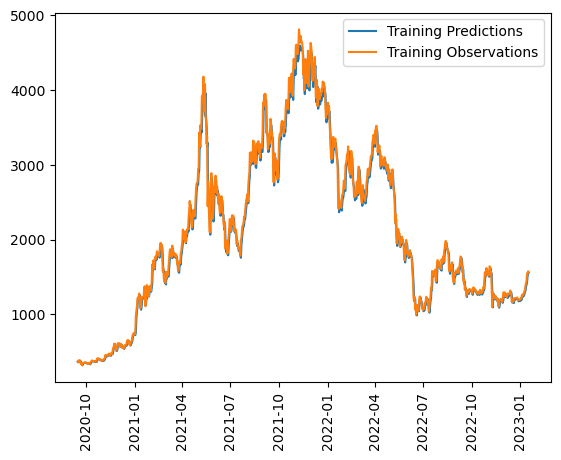

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0009959401795640588
Val MAE: 0.024062450975179672


5/5 [==============================] - 0s 21ms/step


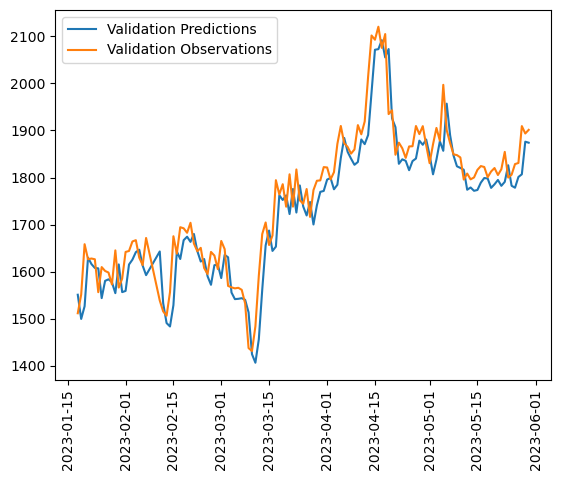

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.000530155492015183
Test MAE: 0.01772361621260643


4/4 [==============================] - 0s 11ms/step


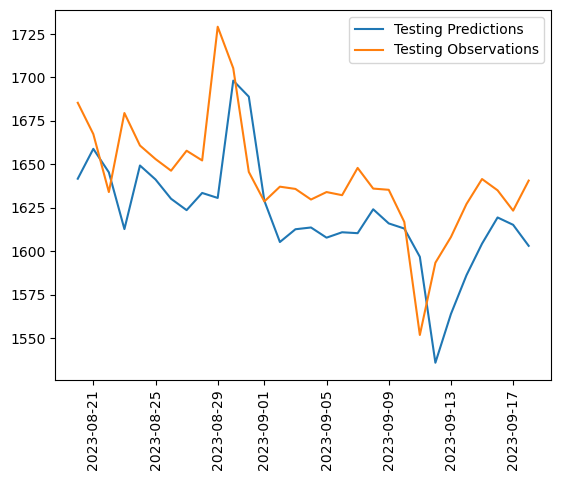

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2[-30:], np.exp(test_predictions3[-30:]))
plt.plot(dates_test2[-30:],np.exp(y_test2[-30:]))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.8654155311400644


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [32]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 25ms/step
[7.3796515, 7.3766627, 7.376942, 7.3771887, 7.377239, 7.377294, 7.3773575]
2023-09-19
2023-09-20
2023-09-21
2023-09-22
2023-09-23
2023-09-24
2023-09-25


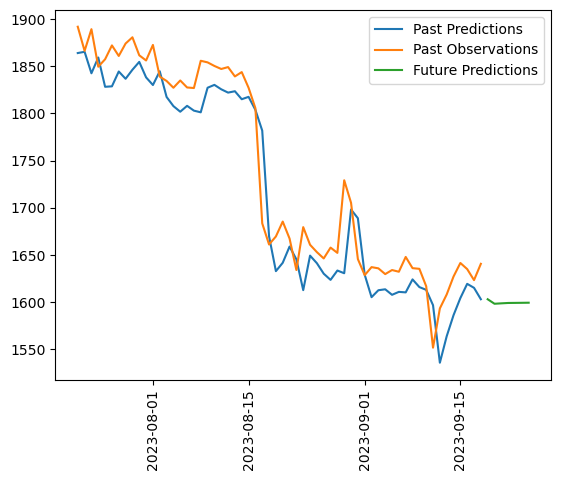

In [33]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [34]:
# Export model to HDF5 file
model.save("H5_Files/eth_30_day_1.h5")

In [35]:
# Export model to HDF5 file
model2.save("H5_Files/eth_30_day_2.h5")

In [36]:
# Export model to HDF5 file
model3.save("H5_Files/eth_30_day_3.h5")

In [37]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)

# df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
# df2.set_index('Date', inplace=True)                   
                    
# past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


df

,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-06-20,1792.4,1826.348877,1766.014282,1711.332153
2023-06-21,1889.8,1873.546021,1787.601074,1763.880859
2023-06-22,1872.6,1968.188477,1831.739014,1858.845581
2023-06-23,1893.7,1986.855225,1865.213501,1856.149292
2023-06-24,1876.2,1997.961426,1897.038696,1868.207886
...,...,...,...,...
2023-09-14,1627.1,1684.114258,1659.357056,1586.120117
2023-09-15,1641.5,1708.454712,1665.126587,1604.279053
2023-09-16,1635.0,1726.542236,1674.691406,1619.368286


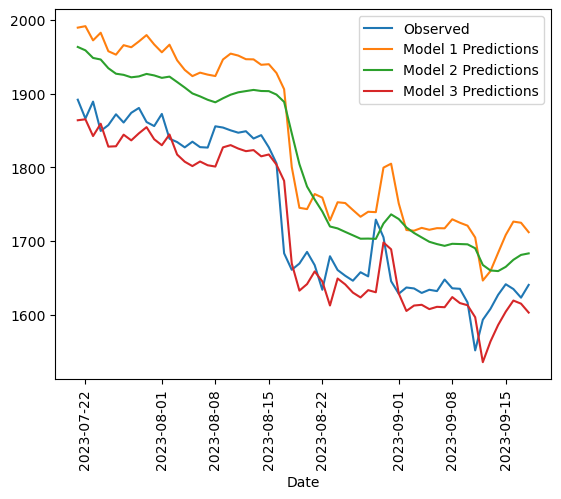

In [38]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [39]:
#output prediction data to csv
df.to_csv('output/eth_predict_30.csv') 

In [40]:
#output original historical data to csv
data.to_csv('output/eth_lifetime_30.csv')

In [41]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.38971479730248415
Model 2 R2 Score:  0.5180416981833292
Model 3 R2 Score:  0.8654155311400644
